# FINAL PROJECT: Portfolio Optimization using Sharpe Ratio

**Course:** [MATH204] Introduction to Quantitative Finance  
**Semester:** Fall 2025  
**Instructor:** Le Tan  

## Group 2

**Team Members:**

- Vu Thi Khanh Ngoc  
- Nguyen Thi Thanh Mai  
- Ngo Nhi  
- Nguyen Le Na  
- Vi Thi Thu Ha  

---

## Project Description

This project focuses on **portfolio optimization** using the **Sharpe Ratio** as the performance metric. The goal is to determine the optimal allocation of a portfolio across three assets—Gold, Bonds, and Stocks—by maximizing the risk-adjusted return. 

We analyze historical monthly log returns of these assets from **2015 to 2025**, compute annualized mean returns and covariances, and apply **constrained optimization** to obtain optimal weights under different scenarios:

- Full investment with long-only constraints  
- Minimum and maximum allocation constraints for specific assets (e.g., Gold ≥ 50%, Bond ≤ 30%)  

The results are visualized using **efficient frontiers** and **stacked bar charts** to illustrate the changing portfolio allocations over the years. This approach helps investors understand how risk and return trade-offs influence portfolio decisions in different market conditions.


In [ ]:
# Google Colab setup command to install PyPortfolioOpt
# !pip install git+https://github.com/robertmartin8/PyPortfolioOpt.git

  Cloning https://github.com/robertmartin8/PyPortfolioOpt.git to c:\users\hehe\appdata\local\temp\pip-req-build-n4960xes
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  Running command git clone -q https://github.com/robertmartin8/PyPortfolioOpt.git 'C:\Users\hehe\AppData\Local\Temp\pip-req-build-n4960xes'
  ERROR: Command errored out with exit status 1:
   command: 'c:\users\hehe\appdata\local\programs\python\python38\python.exe' 'c:\users\hehe\appdata\local\programs\python\python38\lib\site-packages\pip' install --ignore-installed --no-user --prefix 'C:\Users\hehe\AppData\Local\Temp\pip-build-env-sn7ij7hh\overlay' --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'setuptools>=78.1.1'
       cwd: None
  Complete output (4 lines):
  ERROR: Could not find a version that satisfies the requirement setuptools>=78.1.1 (from versions: 0.6b1, 0.6b2, 0.6b3, 0.6b4, 0.6rc1, 0.6rc2, 0.6rc3, 0.6rc4, 0.6rc5, 0.6rc6, 0.6rc7, 0.6rc8, 0.6rc9, 0.6rc10, 0.6rc11, 0.7.2, 0.7.3, 0.7.4, 0.7.5, 0.7.6, 0.7.7, 0.7.8, 0.8, 0.9, 0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6, 0.9.7, 0.9.8, 1.0, 1.1, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.

laays data cuoi cung cua 1 thang

In [1]:
# Import necessary libraries:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, expected_returns, risk_models, plotting
from pypfopt.objective_functions import L2_reg
from pypfopt import EfficientFrontier, risk_models, expected_returns

## Data Preparation

### Merge into one DataFrame

In [2]:
# Read all dataset

# Google Colab file paths 
# bond = pd.read_csv("/content/bond_yield_daily.csv")
# stock = pd.read_csv("/content/stock_index_daily.csv")
# gold = pd.read_csv("/content/gold_prices_daily.csv")

# Local file paths
bond = pd.read_csv("data/bond_yield_daily.csv")
stock = pd.read_csv("data/stock_index_daily.csv")
gold = pd.read_csv("data/gold_prices_daily.csv")

In [3]:
# Check if there exists NaN values
print(bond.isna().sum())
print(stock.isna().sum())
print(gold.isna().sum())

Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
% Thay đổi    0
dtype: int64
Ngày          0
Lần cuối      0
Mở            0
Cao           0
Thấp          0
KL            0
% Thay đổi    0
dtype: int64
date              0
gold_price_vnd    0
dtype: int64


In [4]:
# Reverse the order
bond = bond.iloc[::-1].reset_index(drop=True)
stock = stock.iloc[::-1].reset_index(drop=True)

# Bond & Stock have date format: "01/10/2025" (day/month/year)
bond['date'] = pd.to_datetime(bond['Ngày'], format="%d/%m/%Y", errors='coerce')
stock['date'] = pd.to_datetime(stock['Ngày'], format="%d/%m/%Y", errors='coerce')

# Gold has format: "2025-08-15" (year-month-day)
gold['date'] = pd.to_datetime(gold['date'], format="%Y-%m-%d")

# Remove currency symbol and thousand separators
gold['gold_price_vnd'] = (
    gold['gold_price_vnd']
    .astype(str)
    .str.replace('₫', '', regex=False)
    .str.replace(',', '', regex=False)   # REMOVE COMMAS
    .str.strip()                         # remove any extra spaces
)

# Convert data values to numeric
bond['Lần cuối'] = pd.to_numeric(bond['Lần cuối'].astype(str).str.replace(',', '').str.strip(), errors='coerce')
stock['Lần cuối'] = pd.to_numeric(stock['Lần cuối'].astype(str).str.replace(',', '').str.strip(), errors='coerce')
gold['gold_price_vnd'] = pd.to_numeric(gold['gold_price_vnd'], errors='coerce')

In [ ]:
gold['date'] = pd.to_datetime(gold['date'])
bond['date'] = pd.to_datetime(bond['date'])
stock['date'] = pd.to_datetime(stock['date'])

gold = gold.sort_values("date")
gold["month_year"] = gold["date"].dt.to_period("M")

# Fetch the last entry for each month
gold_last = (
    gold.groupby("month_year")
        .tail(1)[["month_year", "gold_price_vnd"]]
        .reset_index(drop=True)
)

bond = bond.sort_values("date")
bond["month_year"] = bond["date"].dt.to_period("M")

bond_last = (
    bond.groupby("month_year")
        .tail(1)[["month_year", "Lần cuối"]]
        .rename(columns={"Lần cuối": "bond_yield"})
        .reset_index(drop=True)
)

stock = stock.sort_values("date")
stock["month_year"] = stock["date"].dt.to_period("M")

stock_last = (
    stock.groupby("month_year")
        .tail(1)[["month_year", "Lần cuối"]]
        .rename(columns={"Lần cuối": "stock_index"})
        .reset_index(drop=True)
)

# Merge datasets on month_year
df = (
    gold_last
    .merge(bond_last, on="month_year", how="inner")
    .merge(stock_last, on="month_year", how="inner")
)

df["month_year"] = df["month_year"].astype(str)

# df = df.iloc[:-1]

df

,month_year,gold_price_vnd,bond_yield,stock_index
0,2015-10,25515650.0,7.062,607.37
1,2015-11,23967860.0,7.060,573.20
2,2015-12,23846470.0,7.052,579.03
3,2016-01,24848700.0,7.037,545.25
4,2016-02,27664260.0,6.863,559.37
...,...,...,...,...
115,2025-05,85599700.0,3.220,1332.60
116,2025-06,86272600.0,3.335,1376.07
117,2025-07,86198000.0,3.448,1502.52
118,2025-08,90842700.0,3.689,1682.21


### Take log return of monthly asset price

Log returns are computed using:

$$
\ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Where:
- $P_t$ is the price at time $t$
- $P_{t-1}$ is the price in the previous period


In [26]:
df_returns = df.copy()

# Compute log returns
df_returns['gold_log_return'] = np.log(df_returns['gold_price_vnd'] / df_returns['gold_price_vnd'].shift(1))
df_returns['bond_log_return'] = np.log(df_returns['bond_yield'] / df_returns['bond_yield'].shift(1))
df_returns['stock_log_return'] = np.log(df_returns['stock_index'] / df_returns['stock_index'].shift(1))

# Drop the first row (NaN from shift)
df_returns = df_returns.dropna().reset_index(drop=True)

print(df_returns.tail())

    month_year  gold_price_vnd  bond_yield  stock_index  gold_log_return  \
114    2025-05      85599700.0       3.220      1332.60         0.000861   
115    2025-06      86272600.0       3.335      1376.07         0.007830   
116    2025-07      86198000.0       3.448      1502.52        -0.000865   
117    2025-08      90842700.0       3.689      1682.21         0.052482   
118    2025-09     101969000.0       3.761      1661.70         0.115539   

     bond_log_return  stock_log_return  
114         0.007481          0.083130  
115         0.035091          0.032100  
116         0.033322          0.087912  
117         0.067561          0.112965  
118         0.019329         -0.012267  


### Annualize


$$
\text{Annualized Mean Return} = \text{Mean Monthly Return} \times 12
$$


$$
\text{Annual Covariance} = \text{Monthly Covariance} \times 12
$$


$$
\text{Annual Standard Deviation} = \text{Monthly Standard Deviation} \times \sqrt{12}
$$


In [12]:
# Select log return columns
returns = df_returns[['gold_log_return', 'bond_log_return', 'stock_log_return']]

# Annualize mean return vector
mean_return_annual = returns.mean() * 12

# Annualize covariance matrix
cov_matrix_annual = returns.cov() * 12

# Annualize
std_annual = returns.std() * np.sqrt(12)

print("Annualized Mean Return Vector:")
print(mean_return_annual)

print("\nAnnualized Covariance Matrix:")
print(cov_matrix_annual)

print("\nAnnualized Standard Deviation:")
print(std_annual)


Annualized Mean Return Vector:
gold_log_return     0.139702
bond_log_return    -0.063534
stock_log_return    0.101492
dtype: float64

Annualized Covariance Matrix:
                  gold_log_return  bond_log_return  stock_log_return
gold_log_return          0.018634        -0.002168          0.001082
bond_log_return         -0.002168         0.061624         -0.023027
stock_log_return         0.001082        -0.023027          0.042856

Annualized Standard Deviation:
gold_log_return     0.136505
bond_log_return     0.248243
stock_log_return    0.207017
dtype: float64


# QUESTION 1: Which types of assets have the highest Sharpe ratio in Vietnam?

$$
\text{Sharpe Ratio} = \frac{\mu_{\text{annual}} - R_f}{\sigma_{\text{annual}}},
\quad \text{where}
\quad
\begin{aligned}
\mu_{\text{annual}} &= \text{annualized mean log return} = \text{mean of monthly log returns} \times 12, \\
\sigma_{\text{annual}} &= \text{annualized standard deviation of log returns} = \text{standard deviation of monthly log returns} \times \sqrt{12}, \\
R_f &= \text{annual risk-free rate}.
\end{aligned}
$$


In [13]:
# Risk-free rate
rf_annual = 0.04

# Sharpe ratio
sharpe_annual = (mean_return_annual - rf_annual) / std_annual

# Build table
stats_table = pd.DataFrame({
    "Gold": [mean_return_annual["gold_log_return"], std_annual["gold_log_return"], sharpe_annual["gold_log_return"]],
    "Bond": [mean_return_annual["bond_log_return"], std_annual["bond_log_return"], sharpe_annual["bond_log_return"]],
    "Stock": [mean_return_annual["stock_log_return"], std_annual["stock_log_return"], sharpe_annual["stock_log_return"]],
},
index=["Mean p.a.", "SD p.a.", "Sharpe ratio p.a."]
)

stats_table

,Gold,Bond,Stock
Mean p.a.,0.139702,-0.063534,0.101492
SD p.a.,0.136505,0.248243,0.207017
Sharpe ratio p.a.,0.730389,-0.417067,0.297037


## QUESTION 2: Efficient frontiers based on 2 cases of constraints




**Objective:** Maximize the Sharpe ratio of a portfolio including the risk-free rate $R_f$:

$$
\max_{w} \text{Sharpe Ratio}(w) = \frac{w^T \mu - R_f}{\sqrt{w^T \Sigma w}}
$$


Source: https://bookdown.org/palomar/portfoliooptimizationbook/7.2-MSRP.html


**Where:**  
- $w = [w_1, w_2, \dots, w_n]^T$ is the vector of portfolio weights  
- $\mu = [\mu_1, \mu_2, \dots, \mu_n]^T$ is the vector of expected annual returns of the assets  
- $\Sigma$ is the covariance matrix of asset returns  
- $R_f$ is the annual risk-free rate  

**Constraints:**  
1. Portfolio weights sum to 1:  
$$
\sum_{i=1}^{n} w_i = 1
$$  
2. Long-only portfolio (no short selling):  
$$
0 \le w_i \le 1, \quad i = 1, \dots, n
$$




*   Gold_min = 5%
*   Bond_max = 30%

In [14]:
# mean return vector and covariance matrix from your data
mu = mean_return_annual.values        # array of expected returns
Sigma = cov_matrix_annual.values      # covariance matrix

Expected annual return: 12.2%
Annual volatility: 11.0%
Sharpe Ratio: 0.74
Expected annual return: 13.2%
Annual volatility: 11.8%
Sharpe Ratio: 0.78


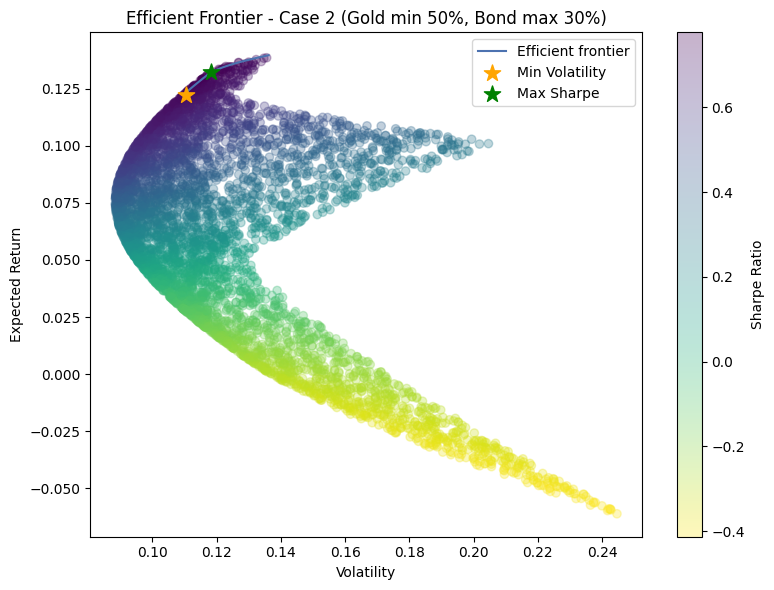

In [19]:

ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
ef_case2.add_constraint(lambda w: w[0] >= 0.05)  # Gold >= 5%
ef_case2.add_constraint(lambda w: w[1] <= 0.03)  # Bond <= 30%

# Minimum volatility
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, _ = ef_min_vol_case2.portfolio_performance(risk_free_rate=rf_annual, verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe2, std_max_sharpe2, _ = ef_max_sharpe_case2.portfolio_performance(risk_free_rate=rf_annual, verbose=True)

fig2, ax2 = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax2, show_assets=False)

# Highlight portfolios
ax2.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility", zorder=10)
ax2.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe", zorder=10)

# Random portfolios
n_samples = 5000
w_random = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets_random = w_random.dot(mu)
stds_random = np.sqrt(np.einsum('ij,jk,ik->i', w_random, Sigma, w_random))
sharpes_random = (rets_random - rf_annual) / stds_random
sc2 = ax2.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label("Sharpe Ratio")
ax2.set_xlabel("Volatility")
ax2.set_ylabel("Expected Return")
ax2.set_title("Efficient Frontier - Case 2 (Gold min 50%, Bond max 30%)")
ax2.legend()
plt.tight_layout()
plt.show()

Expected annual return: 7.5%
Annual volatility: 8.8%
Sharpe Ratio: 0.40
Expected annual return: 13.2%
Annual volatility: 11.8%
Sharpe Ratio: 0.78


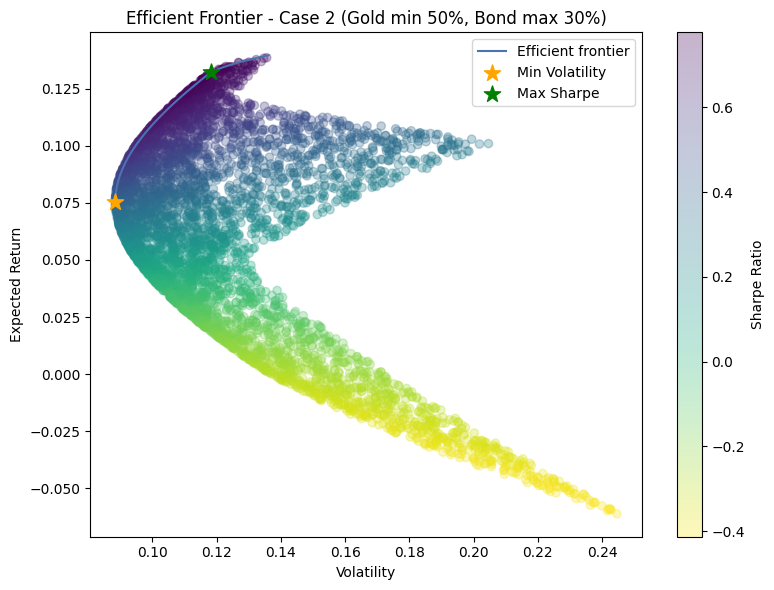

In [21]:

ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
# ef_case2.add_constraint(lambda w: w[0] >= 0.95)  # Gold >= 5%
# ef_case2.add_constraint(lambda w: w[1] <= 0.03)  # Bond <= 30%

# Minimum volatility
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, _ = ef_min_vol_case2.portfolio_performance(risk_free_rate=rf_annual, verbose=True)

# Maximum Sharpe ratio
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=0.04)
ret_max_sharpe2, std_max_sharpe2, _ = ef_max_sharpe_case2.portfolio_performance(risk_free_rate=rf_annual, verbose=True)

fig2, ax2 = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax2, show_assets=False)

# Highlight portfolios
ax2.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility", zorder=10)
ax2.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe", zorder=10)

# Random portfolios
sc2 = ax2.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label("Sharpe Ratio")
ax2.set_xlabel("Volatility")
ax2.set_ylabel("Expected Return")
ax2.set_title("Efficient Frontier - Case 2 (Gold min 50%, Bond max 30%)")
ax2.legend()
plt.tight_layout()
plt.show()

Expected annual return: 5.1%
Annual volatility: 10.2%
Sharpe Ratio: 0.11
Expected annual return: 5.5%
Annual volatility: 11.1%
Sharpe Ratio: 0.13


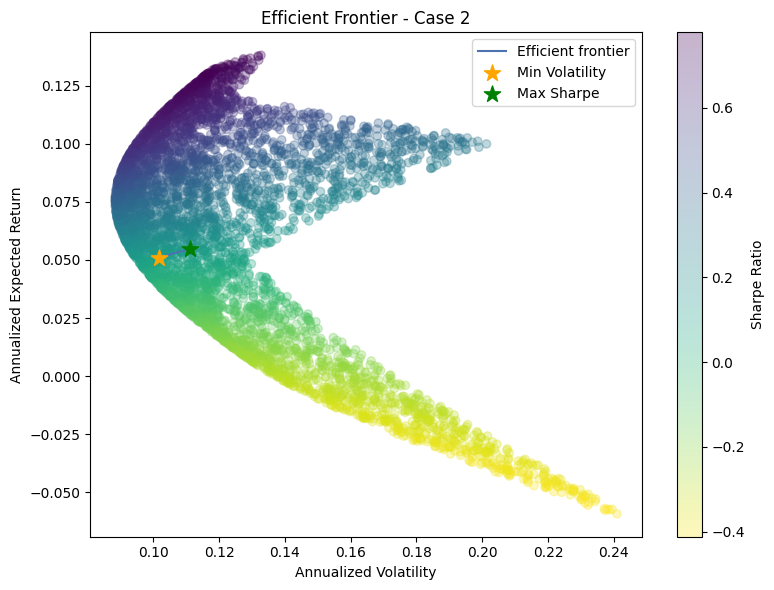

In [25]:

ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))
# ef_case2.add_constraint(lambda w: w[0] >= 0.98)  # Gold >= 5%
# ef_case2.add_constraint(lambda w: w[1] <= 0.02)  # Bond <= 30%
ef_case2.add_constraint(lambda w: w[0] <= 0.50)  # Gold <= 50%
ef_case2.add_constraint(lambda w: w[1] >= 0.40)  # Bond >= 40%
ef_case2.add_constraint(lambda w: w[2] <= 0.20)  # Stock <= 20%
# -----------------------------
# Minimum Volatility Portfolio
# -----------------------------
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, sharpe_min_vol2 = ef_min_vol_case2.portfolio_performance(
    risk_free_rate=rf_annual, verbose=True
)

# -----------------------------
# Maximum Sharpe Ratio Portfolio
# -----------------------------
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=rf_annual)
ret_max_sharpe2, std_max_sharpe2, sharpe_max_sharpe2 = ef_max_sharpe_case2.portfolio_performance(
    risk_free_rate=rf_annual, verbose=True
)

# -----------------------------
# Plot Efficient Frontier
# -----------------------------
fig, ax = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax, show_assets=False)

# Highlight minimum volatility and max Sharpe portfolios
ax.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility", zorder=10 )
ax.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe", zorder=10 )

# Random portfolios for reference
n_samples = 5000
w_random = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets_random = w_random.dot(mu)
stds_random = np.sqrt(np.einsum('ij,jk,ik->i', w_random, Sigma, w_random))
sharpes_random = (rets_random - rf_annual) / stds_random
sc = ax.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Sharpe Ratio")
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Expected Return")
ax.set_title("Efficient Frontier - Case 2")
ax.legend()
plt.tight_layout()
plt.show()

Expected annual return: 38.1%
Annual volatility: 5.1%
Sharpe Ratio: 6.70
Expected annual return: 38.2%
Annual volatility: 5.1%
Sharpe Ratio: 6.71


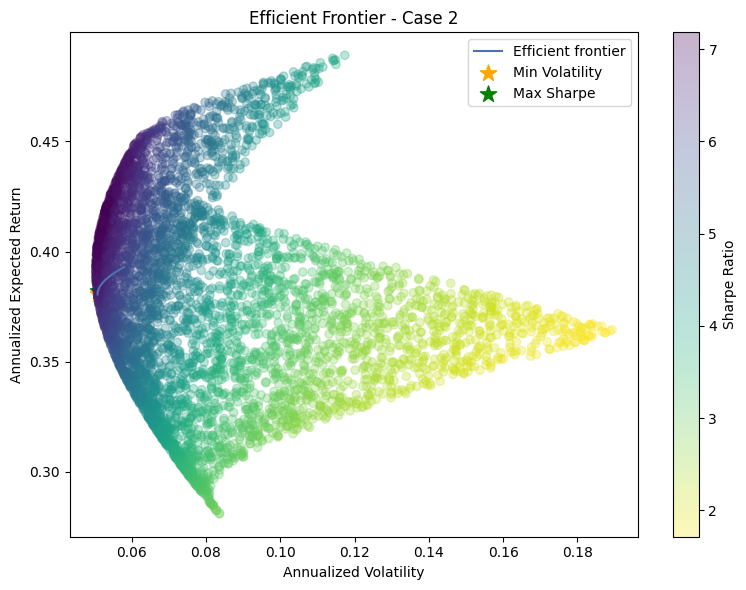

In [ ]:
# -----------------------------
# Case 2
# -----------------------------
ef_case2 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1))

# Constraints
ef_case2.add_constraint(lambda w: w[0] <= 0.50)  # Gold <= 50%
ef_case2.add_constraint(lambda w: w[1] >= 0.40)  # Bond >= 40%
ef_case2.add_constraint(lambda w: w[2] <= 0.20)  # Stock <= 20%

# -----------------------------
# Minimum Volatility Portfolio
# -----------------------------
ef_min_vol_case2 = ef_case2.deepcopy()
weights_min_vol_case2 = ef_min_vol_case2.min_volatility()
ret_min_vol2, std_min_vol2, sharpe_min_vol2 = ef_min_vol_case2.portfolio_performance(
    risk_free_rate=rf_annual, verbose=True
)

# -----------------------------
# Maximum Sharpe Ratio Portfolio
# -----------------------------
ef_max_sharpe_case2 = ef_case2.deepcopy()
weights_max_sharpe_case2 = ef_max_sharpe_case2.max_sharpe(risk_free_rate=rf_annual)
ret_max_sharpe2, std_max_sharpe2, sharpe_max_sharpe2 = ef_max_sharpe_case2.portfolio_performance(
    risk_free_rate=rf_annual, verbose=True
)

# -----------------------------
# Plot Efficient Frontier
# -----------------------------
fig, ax = plt.subplots(figsize=(8,6))
plotting.plot_efficient_frontier(ef_case2, ax=ax, show_assets=False)

# Highlight minimum volatility and max Sharpe portfolios
ax.scatter(std_min_vol2, ret_min_vol2, marker="*", s=150, c="orange", label="Min Volatility")
ax.scatter(std_max_sharpe2, ret_max_sharpe2, marker="*", s=150, c="green", label="Max Sharpe")

# Random portfolios for reference
n_samples = 5000
w_random = np.random.dirichlet(np.ones(n), n_samples)
rets_random = w_random.dot(mu)
stds_random = np.sqrt(np.einsum('ij,jk,ik->i', w_random, Sigma, w_random))
sharpes_random = (rets_random - rf_annual) / stds_random
sc = ax.scatter(stds_random, rets_random, c=sharpes_random, cmap="viridis_r", alpha=0.3)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Sharpe Ratio")
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Expected Return")
ax.set_title("Efficient Frontier - Case 2")
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Case 1: Maximum Sharpe Ratio weights
print("Maximum Sharpe Ratio Weights (Case 1):")
for asset, weight in zip(['Gold', 'Bond', 'Stock'], weights_max_sharpe_case1.values()):
    print(f"{asset}: {weight:.2%}")

# Case 1: Minimum Volatility weights
print("\nMinimum Volatility Weights (Case 1):")
for asset, weight in zip(['Gold', 'Bond', 'Stock'], weights_min_vol_case1.values()):
    print(f"{asset}: {weight:.2%}")

# Check against Case 2 constraints
gold_constraint = 0.50
bond_constraint = 0.30

print("\nDo the Case 1 weights satisfy Case 2 constraints?")
print(f"Max Sharpe - Gold >= 50%? {'Yes' if list(weights_max_sharpe_case1.values())[0] >= gold_constraint else 'No'}")
print(f"Max Sharpe - Bond <= 30%? {'Yes' if list(weights_max_sharpe_case1.values())[1] <= bond_constraint else 'No'}")
print(f"Min Vol - Gold >= 50%? {'Yes' if list(weights_min_vol_case1.values())[0] >= gold_constraint else 'No'}")
print(f"Min Vol - Bond <= 30%? {'Yes' if list(weights_min_vol_case1.values())[1] <= bond_constraint else 'No'}")


Maximum Sharpe Ratio Weights (Case 1):
Gold: 77.71%
Bond: 0.00%
Stock: 22.29%

Minimum Volatility Weights (Case 1):
Gold: 49.48%
Bond: 20.98%
Stock: 29.54%

Do the Case 1 weights satisfy Case 2 constraints?
Max Sharpe - Gold >= 50%? Yes
Max Sharpe - Bond <= 30%? Yes
Min Vol - Gold >= 50%? No
Min Vol - Bond <= 30%? Yes


* The Max Sharpe portfolio is already “naturally” compliant with the new constraints.
* The Min Vol portfolio is very close to the constraints, so imposing them barely changes the outcome.
* That’s why your results from the two codes are nearly identical.

## QUESTION 3: Optimal weight: Static Sharpe Ratio

### Case 1: No weight allocation constraint

In [13]:
df_returns

,gold_price_vnd,bond_yield,stock_index,gold_log_return,bond_log_return,stock_log_return
month_year,,,,,,
2015-11,2.432134e+07,7.073727,602.326667,-0.060853,0.005602,0.021615
2015-12,2.405079e+07,7.059652,569.667826,-0.011187,-0.001992,-0.055747
2016-01,2.457863e+07,7.056091,548.304500,0.021710,-0.000505,-0.038223
2016-02,2.682969e+07,7.007045,551.670000,0.087632,-0.006975,0.006119
2016-03,2.773421e+07,6.872565,572.673913,0.033158,-0.019379,0.037366
...,...,...,...,...,...,...
2025-05,8.541415e+07,3.191600,1301.096000,0.023646,0.014867,0.067215
2025-06,8.746790e+07,3.281429,1343.840476,0.023760,0.027757,0.032325
2025-07,8.737124e+07,3.381652,1465.106957,-0.001106,0.030086,0.086397


In [20]:
df_returns['month_year'] = pd.to_datetime(df_returns['month_year'], format='%Y-%m')
df_returns = df_returns.sort_values('month_year')
# ------------------- Helper function -------------------
def compute_optimal_weights(mu, Sigma, rf_annual):
    n = len(mu)
    def neg_sharpe(w, mu, Sigma):
        return - (w @ mu - rf_annual) / np.sqrt(w @ Sigma @ w)
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0,1) for _ in range(n))
    w0 = np.array([1/n]*n)
    
    result = minimize(neg_sharpe, w0, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# ------------------- Compute yearly weights -------------------
years = range(2015, 2026)
weights_by_year = []

for y in years:
    # Select all data in that year
    df_year = returns[df_returns['month_year'].dt.year == y]
    if len(df_year) == 0:
        # No data for this year, skip
        continue
    # Annualized mean and covariance
    mu_annual = df_year.mean() * 12
    Sigma_annual = df_year.cov() * 12
    # Compute optimal weights
    w_opt = compute_optimal_weights(mu_annual.values, Sigma_annual.values, rf_annual)
    weights_by_year.append([y] + list(w_opt))

# Convert to DataFrame
weights_df = pd.DataFrame(weights_by_year, columns=['Year', 'Gold', 'Bond', 'Stock'])
weights_df.set_index('Year', inplace=True)

# ------------------- Plot stacked bar chart -------------------
colors = ['gold', 'lightblue', 'lightgreen']
weights_df.plot(kind='bar', stacked=True, figsize=(12,6),  color=colors, width=0.8)
plt.title("Optimal Portfolio Allocation per Year (Max Sharpe)")
plt.ylabel("Weight")
plt.xlabel("Year")
plt.xticks(rotation=45)
plt.ylim(0,1)
plt.tight_layout()
plt.show()

KeyError: 'month_year'

### Case 2: Weight allocation constraint: gold x bonds

In [19]:
df_returns.set_index('month_year', inplace=True)
assets = ['Gold', 'Bond', 'Stock']
# Store optimal weights per year
weights_yearly = []
for y in years:
    # Select all months in that year
    returns_year = df_returns[df_returns.index.year == y][['gold_log_return', 'bond_log_return', 'stock_log_return']]
    
    if returns_year.empty:
        # If no data for this year, store NaNs
        weights_yearly.append([np.nan]*len(assets))
        continue
    
    # Compute mean and covariance (annualized)
    mu = returns_year.mean().values * 12
    Sigma = returns_year.cov().values * 12
    n = len(mu)
    
    # Negative Sharpe ratio function
    def neg_sharpe(w, mu, Sigma):
        return - (w @ mu - rf_annual) / np.sqrt(w @ Sigma @ w)
    
    # Constraints: weights sum to 1
    cons = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    
    # Bounds: long-only
    bounds = [(0, 1) for _ in range(n)]
    bounds[0] = (0.05, 1)  # Gold min 50%
    bounds[1] = (0, 0.30)  # Bond max 30%
    
    # Initial guess
    w0 = np.array([0.33, 0.33, 0.34])
    w0[0] = max(w0[0], 0.50)
    w0[1] = min(w0[1], 0.30)
    w0 = w0 / np.sum(w0)
    
    # Optimize
    result = minimize(neg_sharpe, w0, args=(mu, Sigma), method='SLSQP', bounds=bounds, constraints=cons)
    
    if result.success:
        weights_yearly.append(result.x)
    else:
        weights_yearly.append([np.nan]*len(assets))

# Convert to DataFrame
weights_df = pd.DataFrame(weights_yearly, index=years, columns=assets)

# --- Plot stacked bar chart ---
colors = ['gold', 'lightblue', 'lightgreen']
weights_df.plot(kind='bar', stacked=True, figsize=(12,6), color=colors, width=0.8)
plt.ylabel("Portfolio Weight")
plt.xlabel("Year")
plt.title("Optimal Portfolio Weights per Year (Gold >= 50%, Bond <= 30%)")
plt.legend(title="Asset")
plt.tight_layout()
plt.show()

KeyError: "None of ['month_year'] are in the columns"